**Examples of ordinary differential equation discovery with EPDE framework**

This notebook presents an overview of the evolutionary discovery of ODE on examples... 

In [1]:
import numpy as np
import os
import sys

import matplotlib.pyplot as plt
import matplotlib

SMALL_SIZE = 12
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

ADD SOME WORDS ON EPDE PRINCIPLES

In [2]:
import sys
sys.path.append('..')
import helpers

In [3]:
import epde

Principles of equation discovery can be illustrated by a simple example of reconstruction of first-order equation:

\begin{equation}
\label{eq:ODE1}
x \sin{t} + \frac{d x}{d t} \cos{t} = 1,
\end{equation}

where the general solution for an arbitrary constant $C$ is:

\begin{equation}
\label{eq:ODE1_solution}
x = \sin{t} + C \cos{t}.
\end{equation}

To generate the data we will use an analytical particular solution, matching initial condition of $x(0) = 1.3$ (thus, $C = 1.3$) on the interval of $(0, 4 \pi)$:

\begin{equation}
\label{eq:ODE1_part_solution}
x = \sin{t} + 1.3 \cos{t}.
\end{equation}

Furthermore, we will provide an example of using a priori known derivatvies, that can be easily calculated by differentiating the solution:

\begin{equation}
\label{eq:ODE1_deriv_solution}
x' = \cos{t} - 1.3 \sin{t}.
\end{equation}

Text(0, 0.5, 'x')

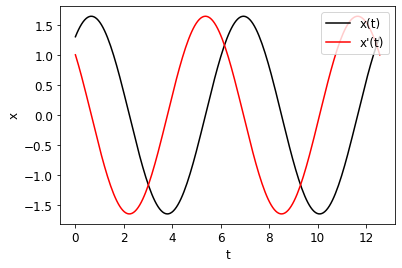

In [4]:
C = 1.3
t = np.linspace(0, 4*np.pi, 200)
x = np.sin(t) + C * np.cos(t)
x_dot = np.cos(t) - C * np.sin(t)

max_axis_idx = x.ndim - 1

plt.plot(t, x, color = 'k', label = 'x(t)')
plt.plot(t, x_dot, color = 'r', label = "x'(t)")
plt.legend(loc = 'upper right')
plt.xlabel('t')
plt.ylabel('x')

Next, we shall initialize the equation search object. Here we are using multiobjective optimization (here, it i denoted explicitly, despite it being the default option). Non-defalut parameter is the size of the boundary: $s_{bnd} = 20$.

Additional parameters will be as follows  population size number of optimziation epochs: $n\_epochs = 30$.

To be able to discovery the correct governing equation, the set of elementary functions (i.e. tokens) (in addition to the derivatives, that are always used) has to include the trigonometric functions. Furthermore, we will include grids to provide diversity of the tokens.

In [5]:
bnd = 20
n_epochs = 55
popsize = 8

epde_search_obj = epde.EpdeSearch(multiobjective_mode = True, boundary = bnd, 
                                  dimensionality = max_axis_idx, coordinate_tensors = [t,])

trig_tokens = epde.TrigonometricTokens(freq = (0.95, 1.05), dimensionality=max_axis_idx)
grid_tokens = epde.GridTokens(['t',], dimensionality = max_axis_idx)

epde_search_obj.set_moeadd_params(population_size = popsize, training_epochs=n_epochs)

setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f038c6336a0>
setting builder with <epde.optimizers.builder.StrategyBuilder object at 0x7f038c6336a0>
trig_token_params: VALUES = (0, 0)
OrderedDict([('power', (1, 1)), ('dim', (0, 0))])


In [ ]:
factors_max_number = {'factors_num' : [1, 2], 'probas' : [0.65, 0.35]}
epde_search_obj.fit(data=[x,], variable_names=['u',], max_deriv_order=(1,), derivs=[x_dot.reshape((-1, 1)),],
                    equation_terms_max_number=4, data_fun_pow = 1,
                    additional_tokens=[trig_tokens, grid_tokens],
                    equation_factors_max_number=factors_max_number,
                    eq_sparsity_interval=(1e-6, 1e-2))

Deriv orders after definition [[None], [0]]
initial_shape (200,) derivs_tensor.shape (200, 1)
self.tokens is ['u', 'du/dx1']
Here, derivs order is {'u': [None], 'du/dx1': [0]}
The cardinality of defined token pool is [2 2 1]
Among them, the pool contains [2 1]
Creating new equation, sparsity value [0.00076255]
New solution accepted, confirmed 1/8 solutions.
Creating new equation, sparsity value [0.00183171]
New solution accepted, confirmed 2/8 solutions.
Creating new equation, sparsity value [5.24202345e-05]
New solution accepted, confirmed 3/8 solutions.
Creating new equation, sparsity value [2.4165782e-06]
Creating new equation, sparsity value [8.11908815e-06]
New solution accepted, confirmed 4/8 solutions.
Creating new equation, sparsity value [0.00185935]
New solution accepted, confirmed 5/8 solutions.
Creating new equation, sparsity value [2.89777378e-05]
New solution accepted, confirmed 6/8 solutions.
Creating new equation, sparsity value [0.0019805]
Creating new equation, sparsi

During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 22-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 23-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 24-th epoch.
During MO : processing 0-th weight.
During 

Multiobjective optimization : 46-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 47-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiobjective optimization : 48-th epoch.
During MO : processing 0-th weight.
During MO : processing 1-th weight.
During MO : processing 2-th weight.
During MO : processing 3-th weight.
During MO : processing 4-th weight.
During MO : processing 5-th weight.
During MO : processing 6-th weight.
During MO : processing 7-th weight.
Multiob

In [8]:
res = epde_search_obj.equations(False)

AttributeError: 'AxesSubplot' object has no attribute 'xlim'

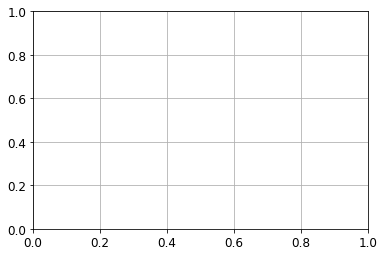

In [8]:
epde_search_obj.visualize_solutions([0, 1])

In [11]:
res[0][2].vals['u'].latex_form

1.0
du/dx1 {'power': (1.0, '1.0')}
1.0
1.0111477781968239
0.0
sin {'power': (1.0, '1.0'), 'freq': (1.0111477781968239, '1.0111'), 'dim': (0.0, '0.0\\cdot 10^{1} ')}
0.010711730171792649
1.0
0.0
t {'power': (1.0, '1.0'), 'dim': (0.0, '0.0\\cdot 10^{1} ')}
1.0001851827385155
1.0
u {'power': (1.0, '1.0')}
1.0
1.009321743148665
0.0
cos {'power': (1.0, '1.0'), 'freq': (1.009321743148665, '1.0093'), 'dim': (0.0, '0.0\\cdot 10^{1} ')}
-1.3003895846708915


'\\frac{\\partial u}{\\partial x1} \\cdot sin^{1.0}(1.0111 x_{0.0\\cdot 10^{1} }) = 1.0712\\cdot 10^{-2} t 1.0002u \\cdot cos^{1.0}(1.0093 x_{0.0\\cdot 10^{1} }) 1.3004'

In [11]:
eq = res[0][1].vals['u']

In [15]:
form = eq.structure[eq.target_idx].latex_form + r' = '
for idx, term in enumerate(eq.structure):
    idx_corrected = idx if idx <= eq.target_idx else idx - 1
    print('test', idx_corrected, idx == eq.target_idx, eq.weights_final[idx_corrected], eq.weights_final[idx_corrected] == 0)
    if idx == eq.target_idx or eq.weights_final[idx_corrected] == 0:
        print('Continuing')
        continue
    print('Did not continue, lul')
    def exp_form(a, sign_num: int = 4):
        print(a)
        exp = np.floor(np.log10(a))
        return np.around(a / 10**exp, sign_num), int(exp)

    digits_rounding_max = 4
    mnt, exp = exp_form(eq.weights_final[idx_corrected], digits_rounding_max)
    exp_str = r'\cdot 10^{{{0}}} '.format(str(exp)) if exp != 0 else ''

    form += str(mnt) + exp_str + term.latex_form + r' '

mnt, exp = exp_form(eq.weights_final[idx_corrected], digits_rounding_max)
exp_str = r'\cdot 10^{{{0}}} '.format(str(exp)) if exp != 0 else 0

form += str(mnt) + exp_str

du/dx1 {'power': 1.0}
sin {'power': 1.0, 'freq': 1.0001151874018293, 'dim': 0.0}
test 0 False 1.000040510307947 False
Did not continue, lul
1.000040510307947
u {'power': 1.0}
cos {'power': 1.0, 'freq': 1.000157275993898, 'dim': 0.0}
test 1 True 0.0 True
Continuing
test 1 False 0.0 True
Continuing
test 2 False 0.0 True
Continuing
0.0


OverflowError: cannot convert float infinity to integer

In [12]:
res[0][0].vals['u'].weights_final[1] == 0

True

In [19]:
res[0][0].vals['u'].target_idx

0

In [16]:
res[0][0].vals['u'].text_form

'0.0 * t{power: 1.0, dim: 0.0} + 0.02423366867815183 * u{power: 1.0} + 0.0 * u{power: 1.0} * t{power: 1.0, dim: 0.0} + 0.6584783864295949 = du/dx1{power: 1.0} * cos{power: 1.0, freq: 1.0469150107786243, dim: 0.0}'

In [17]:
res[0][0].vals['u'].weights_final

array([0.        , 0.02423367, 0.        , 0.65847839])

In [31]:
res[0][0].vals['u'].structure[0].structure[0]._latex_constructor('du/dx1', **{'power' : 1})

'\\frac{\\partial u}{\\partial x1}'

In [34]:
factor = res[0][0].vals['u'].structure[0].structure[0]
if factor._latex_constructor is not None:
    params_dict = {}
    for param_idx, param_info in factor.params_description.items():
        params_dict[param_info['name']] = factor.params[param_idx]

In [37]:
factor._latex_constructor(factor.label, **params_dict)

'\\frac{\\partial u}{\\partial x1}'